In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from behavioural_benchmark.visualisation import Visualisation
sns.set_style("white")

In [2]:
results = pd.read_csv("../results.csv", names=["experiment", "dim", "population_size", "iterations", "function", "metaheuristic", "control_params"] + [f"col_{i}" for i in range(26)])

In [3]:
results.head()

,experiment,dim,population_size,iterations,function,metaheuristic,control_params,col_0,col_1,col_2,...,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25
0,characteristicTest,10,30,1000,Weierstrass,VonNeumannPSO,{c1=0.7; c2=0.7; w=0.9},10,-0.003475,-0.000003,...,0.051248,4840,12,294,800.166667,8.107143,0.631548,1.2975,8.762524,0.037608
1,characteristicTest,10,30,1000,Weierstrass,VonNeumannPSO,{c1=0.7; c2=0.7; w=0.9},30,-0.004983,-0.000021,...,0.060235,4434,23,305,824.400000,8.932203,0.664407,1.3545,6.790226,0.038918
2,characteristicTest,10,30,1000,Weierstrass,VonNeumannPSO,{c1=0.7; c2=0.7; w=0.9},5,-0.004656,-0.000018,...,0.028174,3359,20,300,847.066667,8.258621,0.674138,1.3630,6.123929,0.045055
3,characteristicTest,10,30,1000,Weierstrass,VonNeumannPSO,{c1=0.7; c2=0.7; w=0.9},3,-0.004941,-0.000034,...,0.026478,4374,19,319,809.500000,8.370968,0.672043,1.3235,7.182740,0.062709
4,characteristicTest,10,30,1000,Weierstrass,VonNeumannPSO,{c1=0.7; c2=0.7; w=0.9},21,-0.003746,-0.000010,...,0.025653,5717,30,392,767.300000,8.206897,0.694253,1.2010,9.943356,0.072246


In [4]:
vis = Visualisation(results)

In [5]:
columns = ['col_1', 'col_2']
metaheuristics = ['VonNeumannPSO', 'RingPSO']#, 'GBestPSO']
function = ['Weierstrass']
filter = {"metaheuristic": metaheuristics, "function": function}

In [6]:
prepped_data = vis.__prep_data__(columns=columns, filters=filter, exclude_outliers=True, normalise=True)

# KDE Plots

Text(0, 0.5, '')

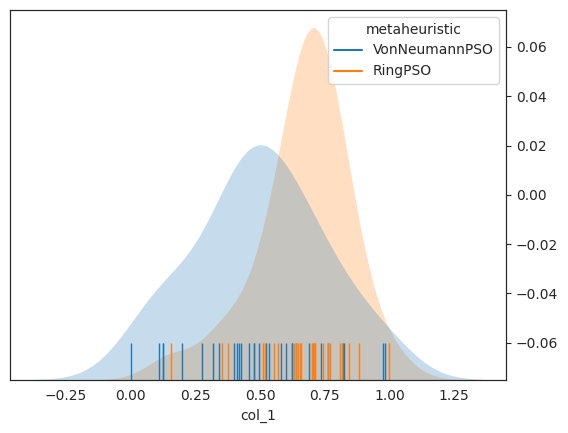

In [7]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
sns.kdeplot(x='col_1', data=prepped_data, hue='metaheuristic', fill=True, ax=ax, linewidth=0, legend=False)
sns.rugplot(x='col_1', data=prepped_data, hue='metaheuristic', ax=ax2, legend=True, height=0.1, clip_on=True)
ax.set_yticks([])
ax.set_ylabel('')

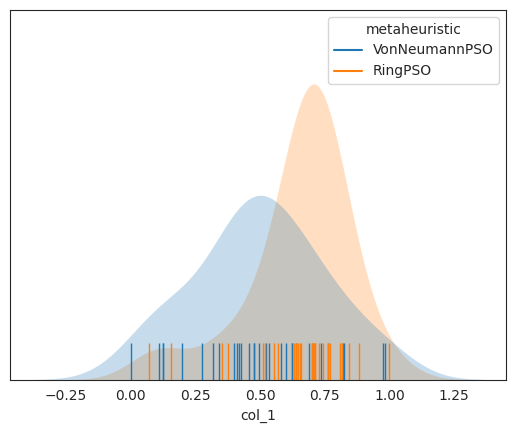

In [8]:
vis.visualise(visualisation_type='kde', columns=['col_1'], filters=filter, exclude_outliers=True, normalise=True)

<Axes: xlabel='col_1', ylabel='col_2'>

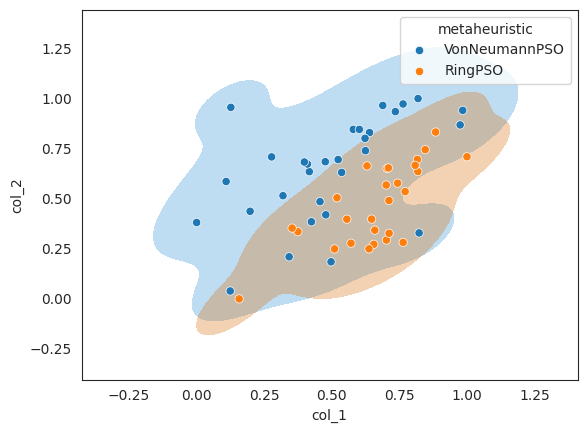

In [9]:
fig, ax = plt.subplots()
sns.set_style("white")
sns.kdeplot(x='col_1', y='col_2', data=prepped_data, hue='metaheuristic', fill=True, alpha=.3, ax=ax, levels=2)
sns.scatterplot(x='col_1', y='col_2', data=prepped_data, hue='metaheuristic', ax=ax)

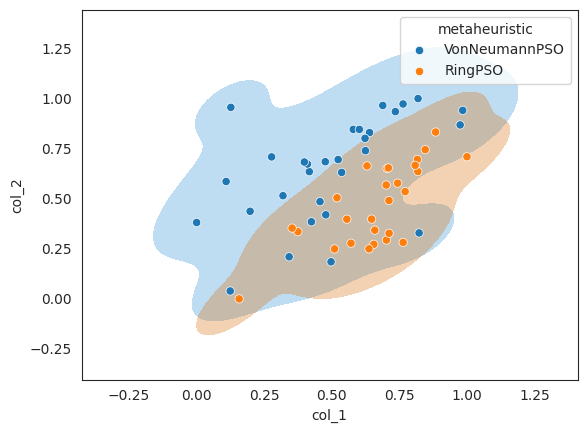

In [10]:
vis.visualise(visualisation_type='kde', columns=columns, filters=filter, exclude_outliers=True, normalise=True)

# Polyhedron

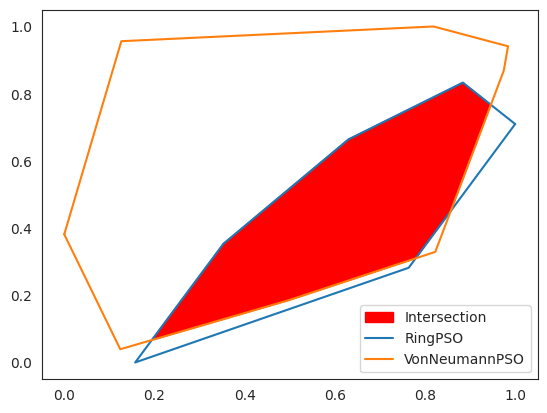

In [11]:
from scipy.spatial import ConvexHull, HalfspaceIntersection
from shapely import Polygon

def get_halfspaces_from_hull(hull):
    """
    Convert the ConvexHull representation to half-spaces for HalfspaceIntersection.
    The half-space format used in scipy is: a dot x + b <= 0.
    """
    # Extract equations for half-spaces
    halfspaces = np.hstack((hull.equations[:, :-1], hull.equations[:, -1][:, np.newaxis]))
    return halfspaces

# Calculate the volume using ConvexHull
hull1 = ConvexHull(prepped_data[prepped_data['metaheuristic'] == 'RingPSO'][columns])
hull2 = ConvexHull(prepped_data[prepped_data['metaheuristic'] == 'VonNeumannPSO'][columns])

# Convert hulls to half-space representations
halfspaces_1 = get_halfspaces_from_hull(hull1)

halfspaces_2 = get_halfspaces_from_hull(hull2)

# Combine all half-spaces from both hulls to find the intersection
all_halfspaces = np.vstack((halfspaces_1, halfspaces_2))

points = prepped_data[columns]
interior_point = np.mean(points, axis=0)
try:
    # Find the intersection
    hs_intersection = HalfspaceIntersection(all_halfspaces, interior_point)
    intersect_hull = ConvexHull(hs_intersection.intersections)
    intersect_p = Polygon(intersect_hull.points[intersect_hull.vertices])
    xc, yc = intersect_p.exterior.xy
    plt.fill(xc, yc, color='red', label='Intersection')
except ValueError:
    # If there is an error in constructing the HalfspaceIntersection, they do not overlap
    print("Convex hulls do not intersect.")
    
p1 = Polygon(hull1.points[hull1.vertices])
p2 = Polygon(hull2.points[hull2.vertices])
x1, y1 = p1.exterior.xy
x2, y2 = p2.exterior.xy
plt.plot(x1, y1, label='RingPSO')
plt.plot(x2, y2, label='VonNeumannPSO')
plt.legend()

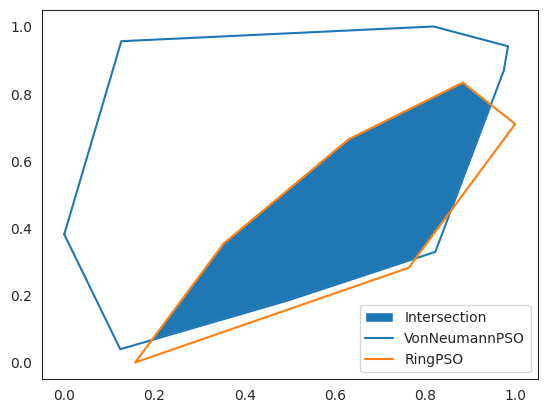

In [12]:
vis.visualise(visualisation_type='polyhedron', columns=columns, filters=filter, exclude_outliers=True, normalise=True)

# Venn Diagram

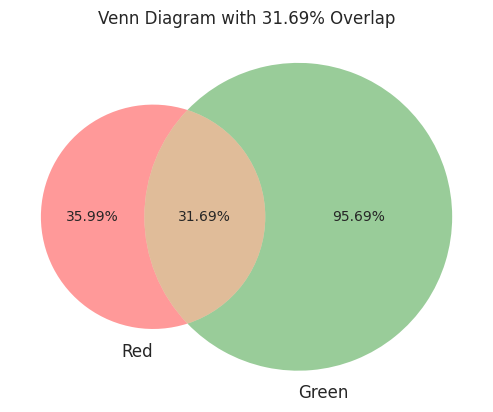

In [13]:
from matplotlib_venn import venn2, venn3

volume_1 = hull1.volume
volume_2 = hull2.volume
intersect_volume = intersect_hull.volume
total_volume = hull1.volume + hull2.volume - intersect_volume

overlap_percentage = intersect_volume / total_volume * 100
percentage_1 = volume_1 / total_volume * 100
percentage_2 = volume_2 / total_volume * 100

# Draw the Venn diagram
venn2(subsets=[percentage_1, percentage_2, overlap_percentage], set_labels=['Red', 'Green'], subset_label_formatter=lambda x: f"{x:.2f}%")

# Add title and display the plot
plt.title(f'Venn Diagram with {overlap_percentage:.2f}% Overlap')
plt.show()

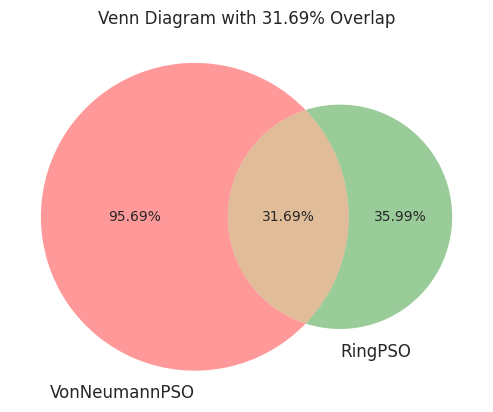

In [14]:
vis.visualise(visualisation_type='venn', columns=columns, filters=filter)

# Testing

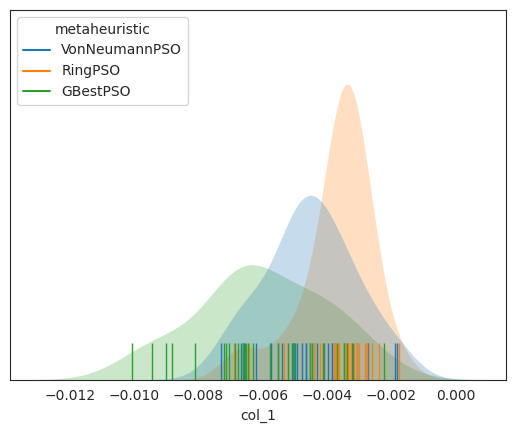

In [27]:
vis.visualise(visualisation_type='kde', columns=['col_1'], filters={"metaheuristic": ['VonNeumannPSO', 'RingPSO', 'GBestPSO'], "function": ['Weierstrass']}, exclude_outliers=True, normalise=False)

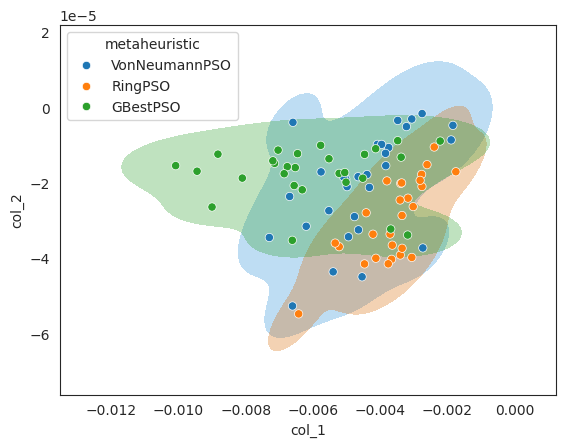

In [25]:
vis.visualise(visualisation_type='kde', columns=['col_1', 'col_2'], filters={"metaheuristic": ['VonNeumannPSO', 'RingPSO', 'GBestPSO'], "function": ['Weierstrass']}, exclude_outliers=True, normalise=False)

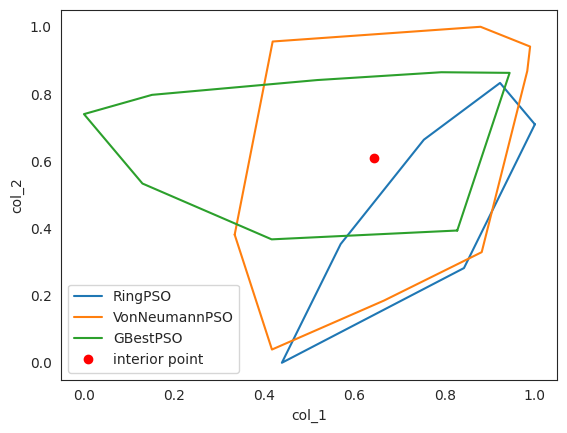

In [53]:
# vis.visualise(visualisation_type='polyhedron', columns=['col_1', 'col_2'], filters={"metaheuristic": ['VonNeumannPSO', 'RingPSO', 'GBestPSO'], "function": ['Weierstrass']}, exclude_outliers=True, normalise=False)

# Calculate the volume using ConvexHull
prepped_data2 = vis.__prep_data__(columns=columns, filters={"metaheuristic": ['VonNeumannPSO', 'RingPSO', 'GBestPSO'], "function": ['Weierstrass']}, exclude_outliers=True, normalise=True)
hull1 = ConvexHull(prepped_data2[prepped_data2['metaheuristic'] == 'RingPSO'][columns])
hull2 = ConvexHull(prepped_data2[prepped_data2['metaheuristic'] == 'VonNeumannPSO'][columns])
hull3 = ConvexHull(prepped_data2[prepped_data2['metaheuristic'] == 'GBestPSO'][columns])

# Convert hulls to half-space representations
halfspaces_1 = get_halfspaces_from_hull(hull1)
halfspaces_2 = get_halfspaces_from_hull(hull2)
halfspaces_3 = get_halfspaces_from_hull(hull3)

# Combine all half-spaces from both hulls to find the intersection
all_halfspaces = np.vstack((halfspaces_1, halfspaces_2, halfspaces_3))
halfspaces_12 = np.vstack((halfspaces_1, halfspaces_2))
halfspaces_13 = np.vstack((halfspaces_1, halfspaces_3))
halfspaces_23 = np.vstack((halfspaces_2, halfspaces_3))

points_all = prepped_data2[columns]
points_12 = prepped_data2[prepped_data2['metaheuristic'].isin(['RingPSO', 'VonNeumannPSO'])][columns]
points_13 = prepped_data2[prepped_data2['metaheuristic'].isin(['RingPSO', 'GBestPSO'])][columns]
points_23 = prepped_data2[prepped_data2['metaheuristic'].isin(['VonNeumannPSO', 'GBestPSO'])][columns]
interior_point_all = np.mean(points_all, axis=0)
interior_point_12 = np.mean(points_12, axis=0)
interior_point_13 = np.mean(points_13, axis=0)
interior_point_23 = np.mean(points_23, axis=0)
try:
    # Find the intersection
    # hs_all_intersection = HalfspaceIntersection(all_halfspaces, interior_point_all)
    # hs_12_intersection = HalfspaceIntersection(halfspaces_12, interior_point_12)
    # hs_13_intersection = HalfspaceIntersection(halfspaces_13, interior_point_13)
    hs_23_intersection = HalfspaceIntersection(halfspaces_23, interior_point_23)
    # intersect_hull = ConvexHull(hs_all_intersection.intersections)
    # intersect_p = Polygon(intersect_hull.points[intersect_hull.vertices])
    # xc, yc = intersect_p.exterior.xy
    # plt.fill(xc, yc, color='red', label='Intersection')
except ValueError:
    # If there is an error in constructing the HalfspaceIntersection, they do not overlap
    print("Convex hulls do not intersect.")
    
p1 = Polygon(hull1.points[hull1.vertices])
p2 = Polygon(hull2.points[hull2.vertices])
p3 = Polygon(hull3.points[hull3.vertices])
x1, y1 = p1.exterior.xy
x2, y2 = p2.exterior.xy
x3, y3 = p3.exterior.xy
plt.plot(x1, y1, label='RingPSO')
plt.plot(x2, y2, label='VonNeumannPSO')
plt.plot(x3, y3, label='GBestPSO')
plt.plot(interior_point['col_1'], interior_point['col_2'], 'ro', label='interior point')
plt.xlabel(columns[0])
plt.ylabel(columns[1])
plt.legend()

In [51]:
interior_point

col_1    0.642644
col_2    0.609366
dtype: float64